<a href="https://colab.research.google.com/github/mgomezo12/GWL_ML_Basis/blob/main/GSEU_ML_IntroWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import os
#os.kill(os.getpid(), 9)

This notebook takes some examples and guidelines from the tensorflow tutorial that you can find here: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=qoFJZmXBaxCc

The adaptations made are in order to serve as examples for an introductory workshop on groundwater level forecasting using deep learning

In [ ]:
import os
import datetime
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
tf.random.set_seed(1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Machine learning workflow - Introduction to groundwater time series data

## Gathering input data



*   Data accessibility
*   Licensing
*   Data format

Besides groundwater data additional information to feed the model is required such as metereological information



### Setup the dataset

Two datasets:
- Groundwater level time series
- Meteorological data

The dataset is in weekly resolution

In [ ]:
#Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/gseu_t41_dataset/mldataset_t1.csv')
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')

In [ ]:
df

,gwl,pr,tm
0,3.20,11.023824,16.794464
1,3.19,0.800202,14.949683
2,3.22,0.000000,15.276594
3,3.20,0.000000,18.337181
4,3.16,0.047861,15.560719
...,...,...,...
2472,NaN,7.601726,8.303526
2473,NaN,1.459518,9.499018
2474,NaN,0.056166,5.358929
2475,NaN,0.867621,11.413746


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gwl     2401 non-null   float64
 1   pr      2477 non-null   float64
 2   tm      2477 non-null   float64
dtypes: float64(3)
memory usage: 58.2 KB


In [ ]:
date_time

0      1968-07-14
1      1968-07-21
2      1968-07-28
3      1968-08-04
4      1968-08-11
          ...    
2472   2015-11-29
2473   2015-12-06
2474   2015-12-13
2475   2015-12-20
2476   2015-12-27
Name: date, Length: 2477, dtype: datetime64[ns]

## Exploratory data analysis (EDA)

Plot the data

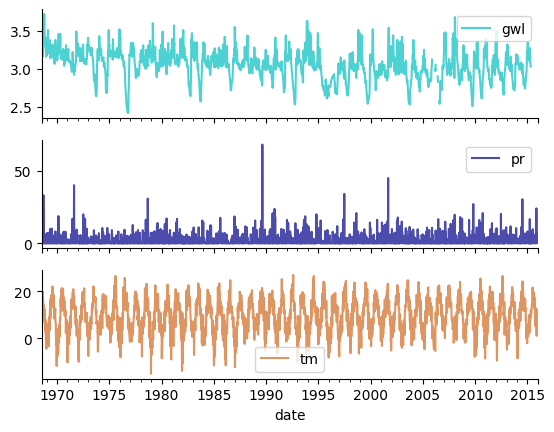

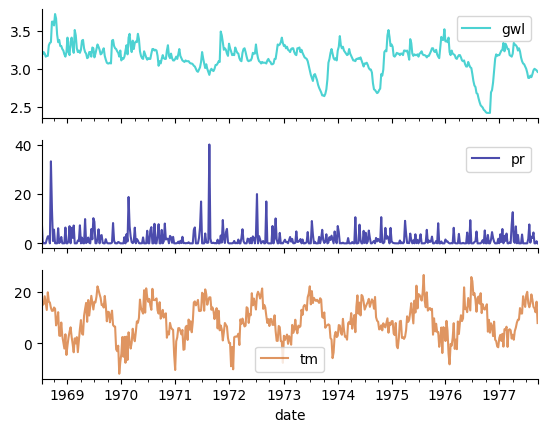

In [ ]:
# Your code to create the initial subplots
plot_cols = ['gwl', 'pr', 'tm']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, color=['c', 'darkblue', 'chocolate'], alpha=0.7)
plt.rcParams['axes.edgecolor'] = 'black'
# Iterate through each subplot to remove upper and right frames
for ax in plt.gcf().get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

# Your code to create the second set of subplots
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, color=['c', 'darkblue', 'chocolate'], alpha=0.7)

# Iterate through each subplot to remove upper and right frames and set their color to black
for ax in plt.gcf().get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

### Data summary

We see it as all the main statistics have a coherent value. This is important to verify how reasonable is our data.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gwl,2401.0,3.052840,0.192950,2.420000,2.950000,3.060000,3.170000,3.720000
pr,2477.0,2.086813,4.054931,0.000000,0.000000,0.276002,2.613746,68.213520
tm,2477.0,9.239411,6.954800,-15.286106,4.300119,9.483880,14.634521,27.092731


### Data visualization/distribution/outliers

<Axes: ylabel='Frequency'>

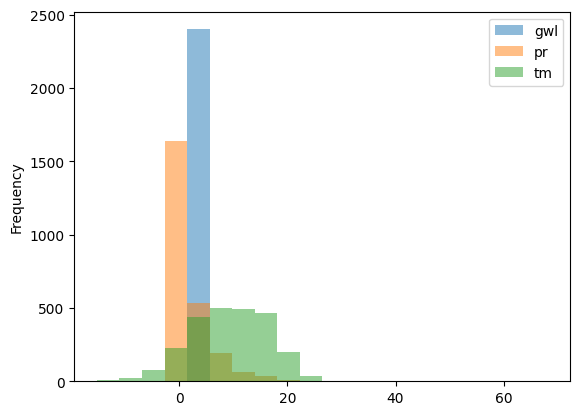

In [ ]:
df.plot.hist(bins=20, alpha=0.5)

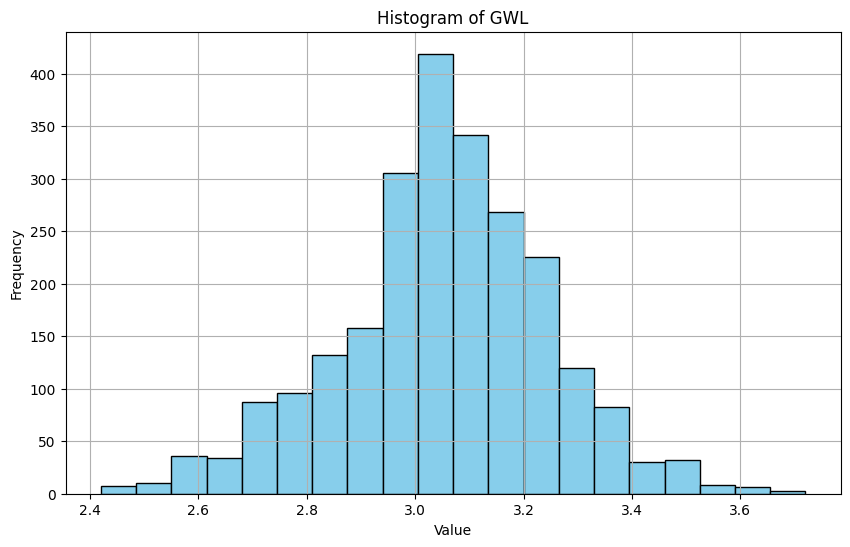

In [ ]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(df['gwl'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of GWL')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: >

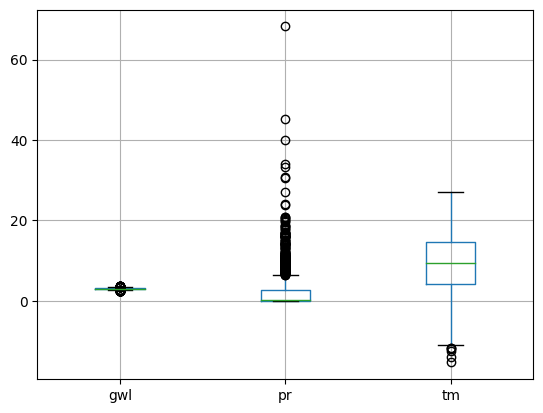

In [ ]:
df.boxplot()

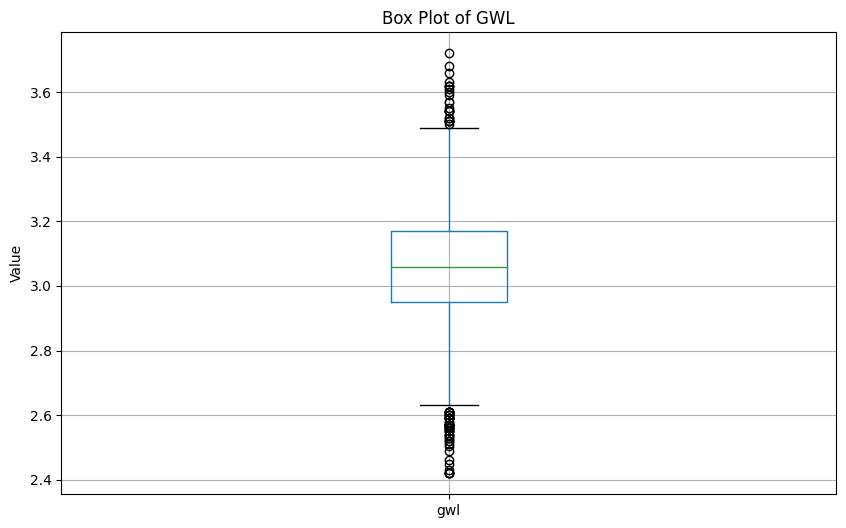

In [ ]:
# Plotting box plot
plt.figure(figsize=(10, 6))
df.boxplot(column='gwl')
plt.title('Box Plot of GWL')
plt.ylabel('Value')
plt.show()

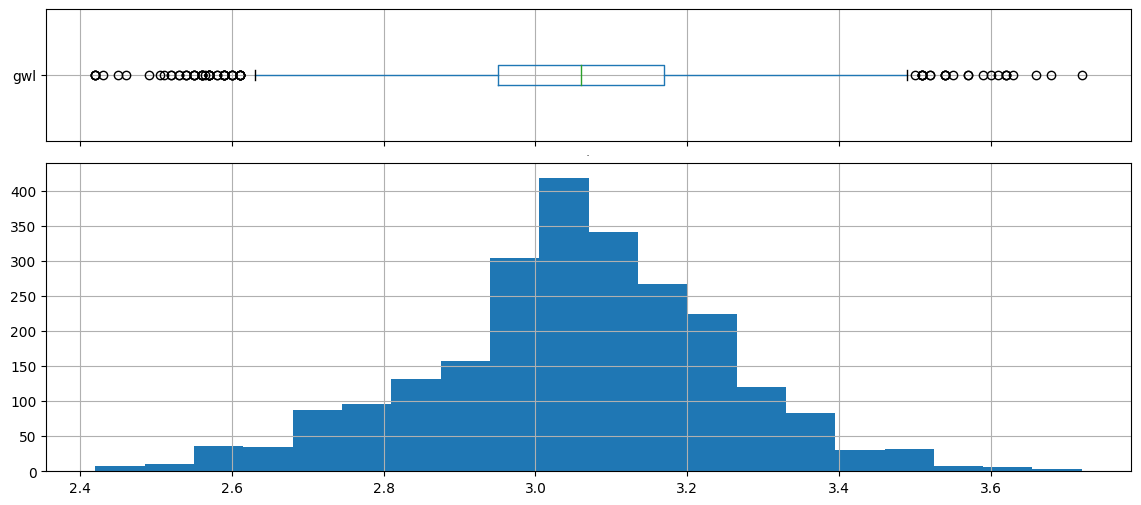

In [ ]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="gwl",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="gwl", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

### Missing values

Machine learning algorithms in tensorflow do not receive datasets with missing values (NaN), so first we should appropiately fill the values. To create a smooth interpolation, we perform a PCHIP (Piecewise Cubic Hermite Interpolating Polynomial).

In [ ]:
df.isna().sum()

gwl    76
pr      0
tm      0
dtype: int64

In [ ]:
#Check for the missing values inside the dataset
nandf = df.set_index(date_time)
nandf=nandf[nandf.gwl.isna()]
len(nandf)

76

In [ ]:
nandf.head()

,gwl,pr,tm
date,,,
2004-11-07,NaN,0.000000,4.018339
2004-11-14,NaN,0.089151,4.094922
2004-11-21,NaN,5.742334,1.943220
2004-11-28,NaN,4.518965,6.136552
2004-12-05,NaN,0.159932,6.342866


In [ ]:
dfc=df.copy()
dfc=dfc.set_index(date_time)
dfin=dfc.interpolate('pchip', order=2) #linear

Remember to review the dataset after the interpolation. In this case, it is not good with the missing values at the end of the period because PCHIP is unable to extrapolate properly. We'd better remove the last missing observation from the dataset.

Text(0, 0.5, 'GWL levels')

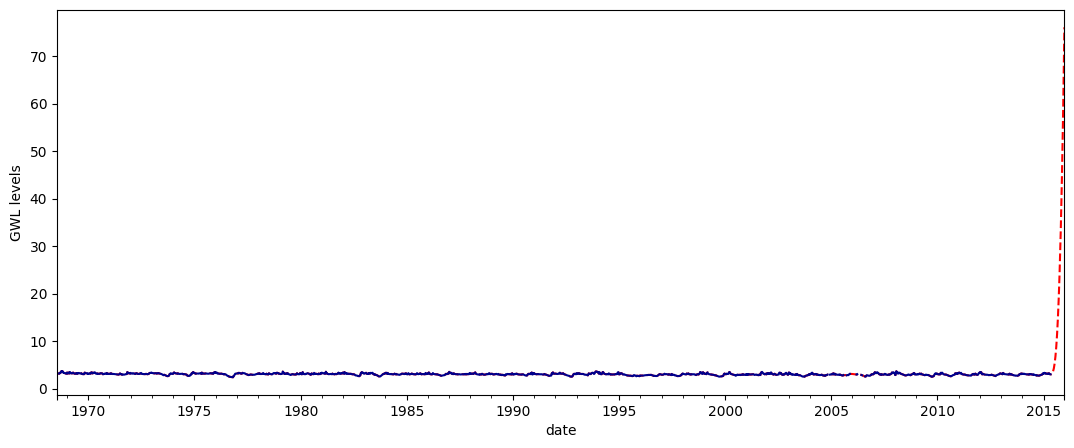

In [ ]:
plt.figure(figsize=(13, 5))
inc=200
#dfin[nandf.index[0]-inc:nandf.index[0]+inc].gwl.plot(color='red', label='Interpolate value', linestyle='dashed')
#dfc[nandf.index[0]-inc:nandf.index[0]+inc].gwl.plot(color='darkblue', label='Observed')
#plt.ylabel('GWL levels')

dfin.gwl.plot(color='red', label='Interpolate value', linestyle='dashed')
dfc.gwl.plot(color='darkblue', label='Observed')
plt.ylabel('GWL levels')

In [ ]:
subset_df = dfc[(dfc.index <= '2015-05-03')]

In [ ]:
subset_df_i=subset_df.interpolate('pchip')

Text(0, 0.5, 'GWL levels')

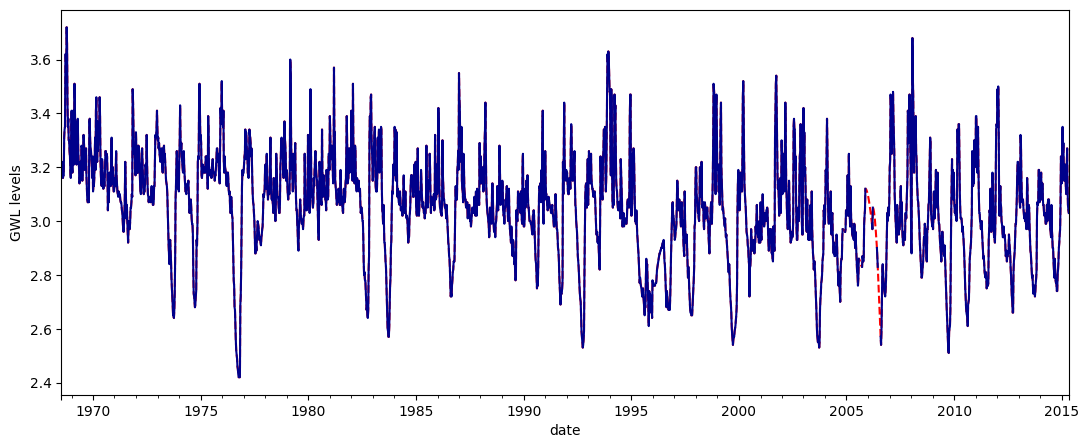

In [ ]:
plt.figure(figsize=(13, 5))
subset_df_i.gwl.plot(color='red', label='Interpolate value', linestyle='dashed')
subset_df.gwl.plot(color='darkblue', label='Observed')
plt.ylabel('GWL levels')

In [ ]:
subset_df = subset_df.interpolate('pchip')

In [ ]:
subset_df.isna().sum()

gwl    0
pr     0
tm     0
dtype: int64

In [ ]:
subset_df

,gwl,pr,tm
date,,,
1968-07-14,3.20,11.023824,16.794464
1968-07-21,3.19,0.800202,14.949683
1968-07-28,3.22,0.000000,15.276594
1968-08-04,3.20,0.000000,18.337181
1968-08-11,3.16,0.047861,15.560719
...,...,...,...
2015-04-05,3.27,0.052624,4.329820
2015-04-12,3.14,0.585845,9.922897
2015-04-19,3.06,0.000000,8.467313


### Correlation analysis

In [ ]:
df = subset_df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2443 entries, 1968-07-14 to 2015-05-03
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gwl     2443 non-null   float64
 1   pr      2443 non-null   float64
 2   tm      2443 non-null   float64
dtypes: float64(3)
memory usage: 76.3 KB


In [ ]:
date_time = df.index
date_time

DatetimeIndex(['1968-07-14', '1968-07-21', '1968-07-28', '1968-08-04',
               '1968-08-11', '1968-08-18', '1968-08-25', '1968-09-01',
               '1968-09-08', '1968-09-15',
               ...
               '2015-03-01', '2015-03-08', '2015-03-15', '2015-03-22',
               '2015-03-29', '2015-04-05', '2015-04-12', '2015-04-19',
               '2015-04-26', '2015-05-03'],
              dtype='datetime64[ns]', name='date', length=2443, freq=None)

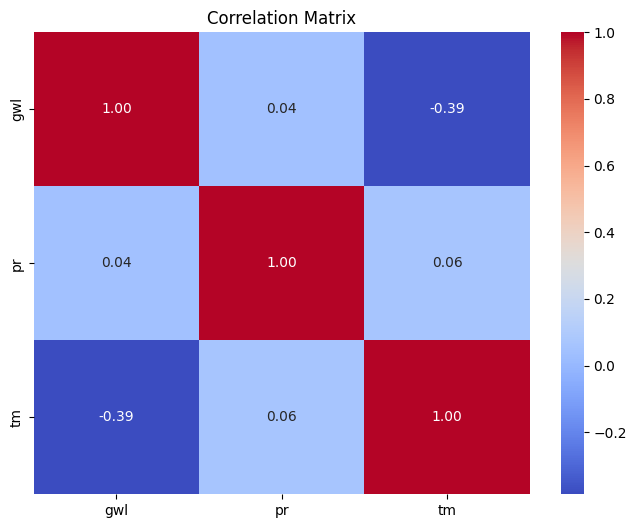

In [ ]:
# Calculate and plot the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

###Time

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# It's a way to represent time as the number of seconds (or milliseconds, depending on precision) since the epoch (00:00:00 Coordinated Universal Time (UTC), Thursday, 1 January 1970).

Weather data has clear daily and yearly periodicity. As we are working with a weekly time resolution, we care for the yearly resolution

Compute the <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. Here is the `tf.signal.rfft` of the temperature over time. Note the obvious peak at frequencies near `1/year`

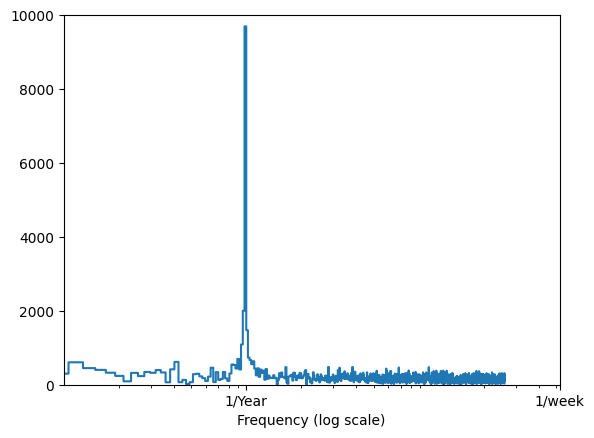

In [ ]:
fft = tf.signal.rfft(df['tm'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['tm'])
hours_per_year = 52
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 52], labels=['1/Year', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
week = 7*24*60*60
year = 52 * week #Number of weeks on a year
df['Tyrsin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Tyrcos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [ ]:
df

,gwl,pr,tm,Tyrsin,Tyrcos
date,,,,,
1968-07-14,3.20,11.023824,16.794464,-0.171759,-0.985139
1968-07-21,3.19,0.800202,14.949683,-0.289252,-0.957253
1968-07-28,3.22,0.000000,15.276594,-0.402527,-0.915408
1968-08-04,3.20,0.000000,18.337181,-0.509933,-0.860214
1968-08-11,3.16,0.047861,15.560719,-0.609902,-0.792477
...,...,...,...,...,...
2015-04-05,3.27,0.052624,4.329820,0.524704,-0.851284
2015-04-12,3.14,0.585845,9.922897,0.418268,-0.908324
2015-04-19,3.06,0.000000,8.467313,0.305732,-0.952118


Text(0.5, 1.0, 'Time of year signal')

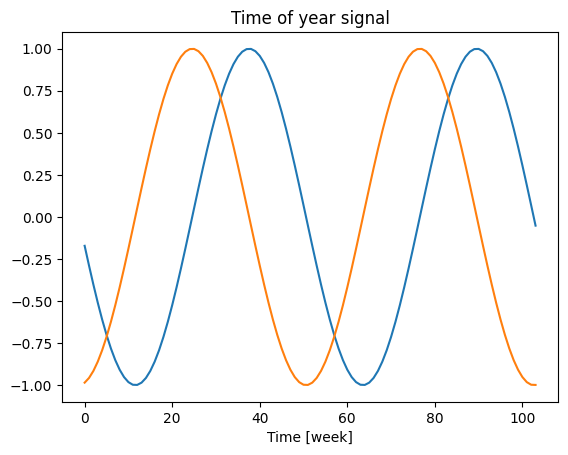

In [ ]:
plt.plot(np.array(df['Tyrsin'])[:104])
plt.plot(np.array(df['Tyrcos'])[:104])
plt.xlabel('Time [week]')
plt.title('Time of year signal')

### Patterns and Trends

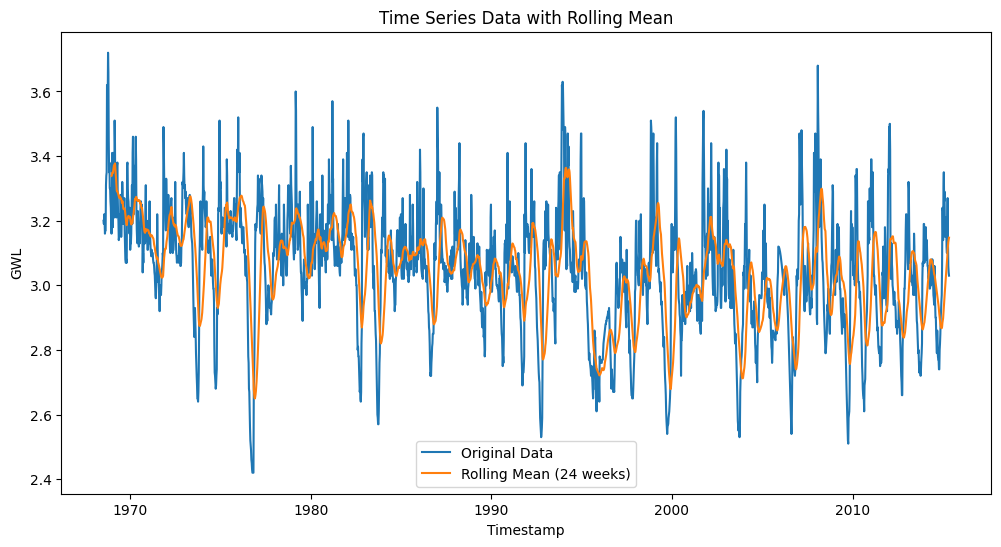

In [ ]:
# Plot a rolling mean for trend analysis
rolling_mean = df['gwl'].rolling(window=24).mean()  # Adjust window size as needed
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['gwl'], label='Original Data')
plt.plot(df.index, rolling_mean, label='Rolling Mean (24 weeks)')
plt.title('Time Series Data with Rolling Mean')
plt.xlabel('Timestamp')
plt.ylabel('GWL')
plt.legend()
plt.show()

Seasonal decomposition

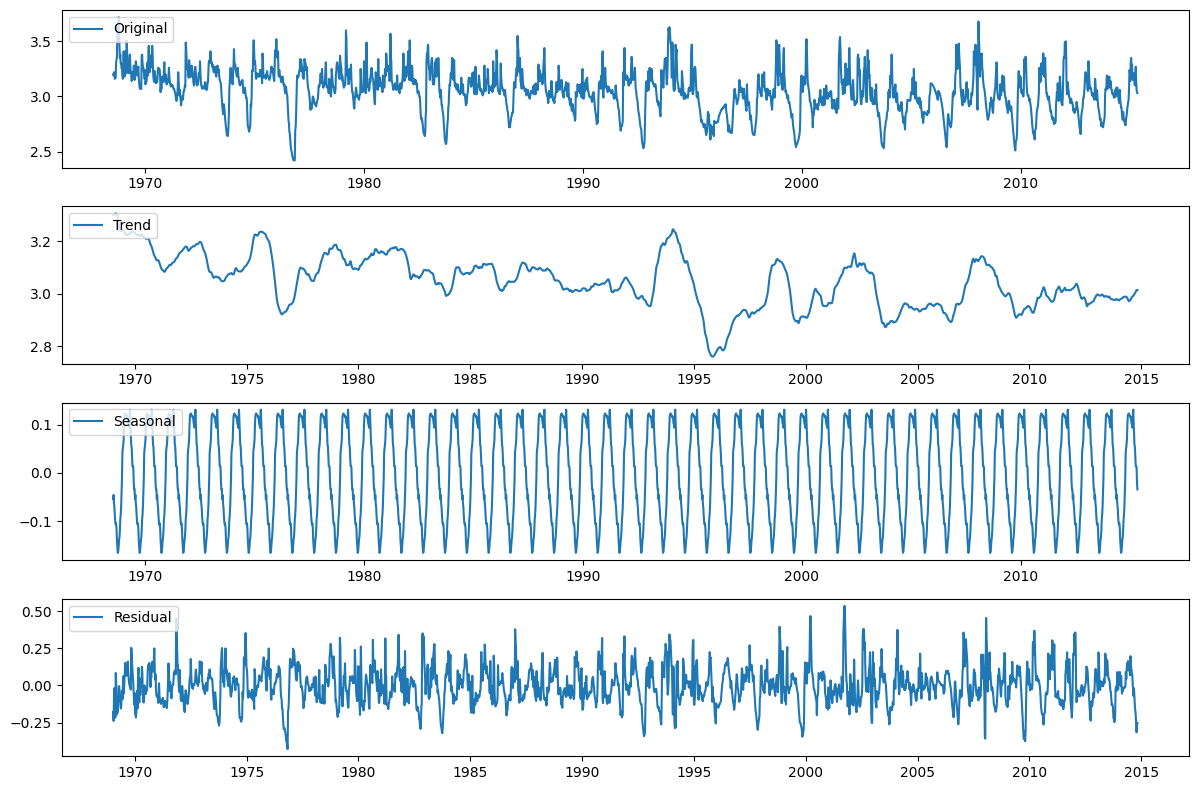

In [ ]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['gwl'], model='additive') #, period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['gwl'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Mann-Kendall test

In [ ]:
! pip install pymannkendall

In [ ]:
import pymannkendall as mk

# Perform the Mann-Kendall trend test
result = mk.original_test(df['gwl'])

# Display the test result
print("Mann-Kendall Test Result:")
print("Trend: ", "Increasing" if result.trend == "increasing" else "Decreasing")
print("p-value: ", result.p)
print("H0: ", "The time series has no trend" if result.h == 0 else "The time series has a trend")

Mann-Kendall Test Result:
Trend:  Decreasing
p-value:  0.0
H0:  The time series has a trend


Autocorrelation plot

(0.0, 104.0)

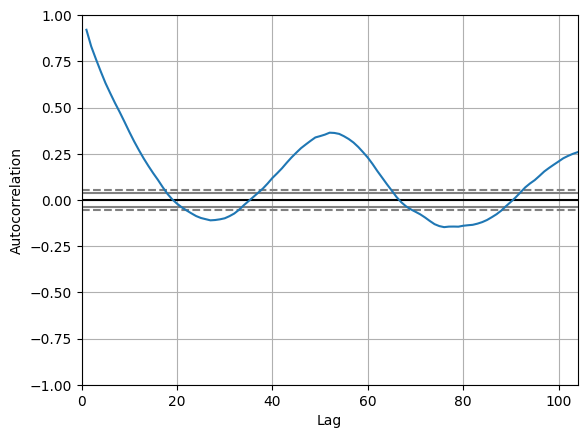

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['gwl']).set_xlim([0, 104])

Shift analysis

<Axes: title={'center': 'Shift Plot'}, xlabel='Date', ylabel='Value Difference'>

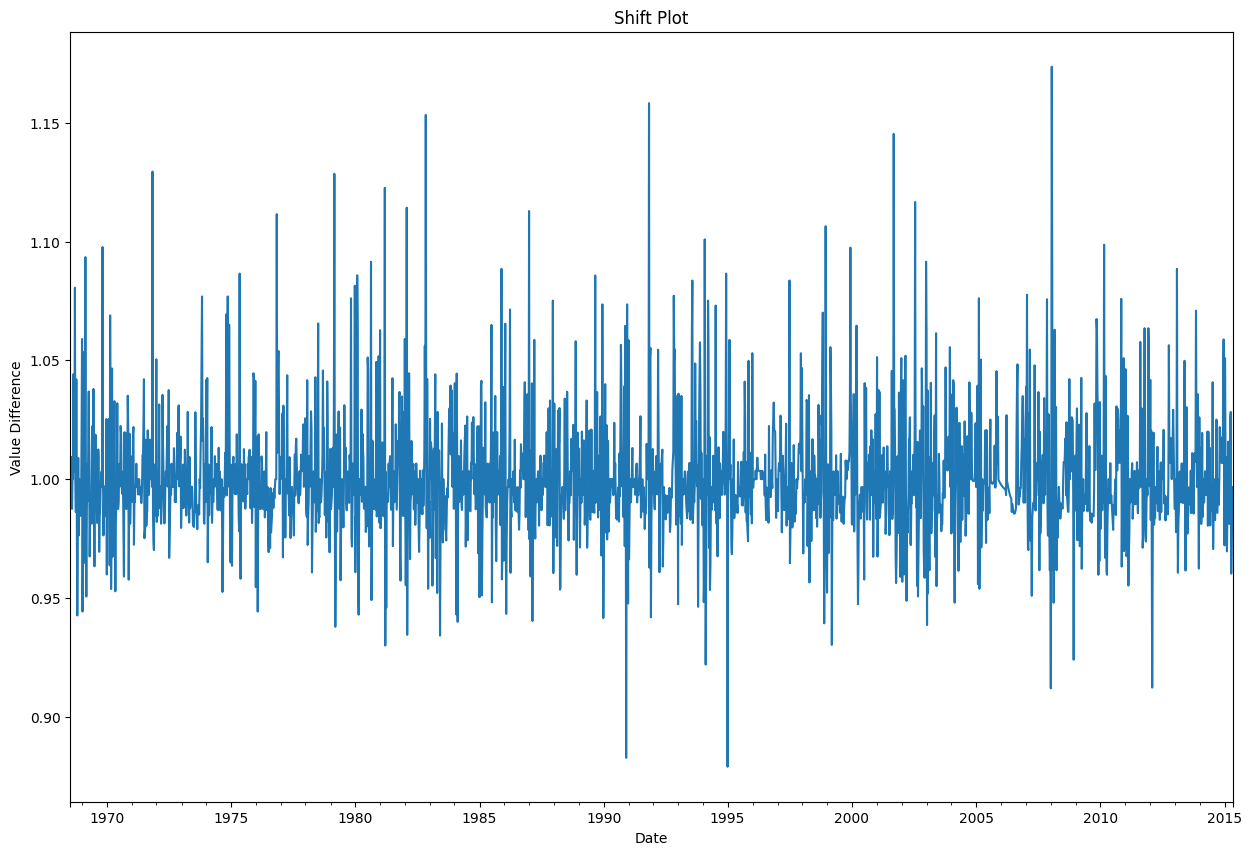

In [ ]:
# This plot the achieved by dividing the current value of the ‘gwl’ column by the shifted value of the ‘gwl’ column. Default Shift is by one value.
# This plot is used to analyze the value stability of the series.

df['Change'] = df.gwl.div(df.gwl.shift())
df['Change'].plot(figsize=(15, 10),
                         xlabel = "Date",
                         ylabel = "Value Difference",
                         title = "Shift Plot")

Plotting Timeseries based Box Plot

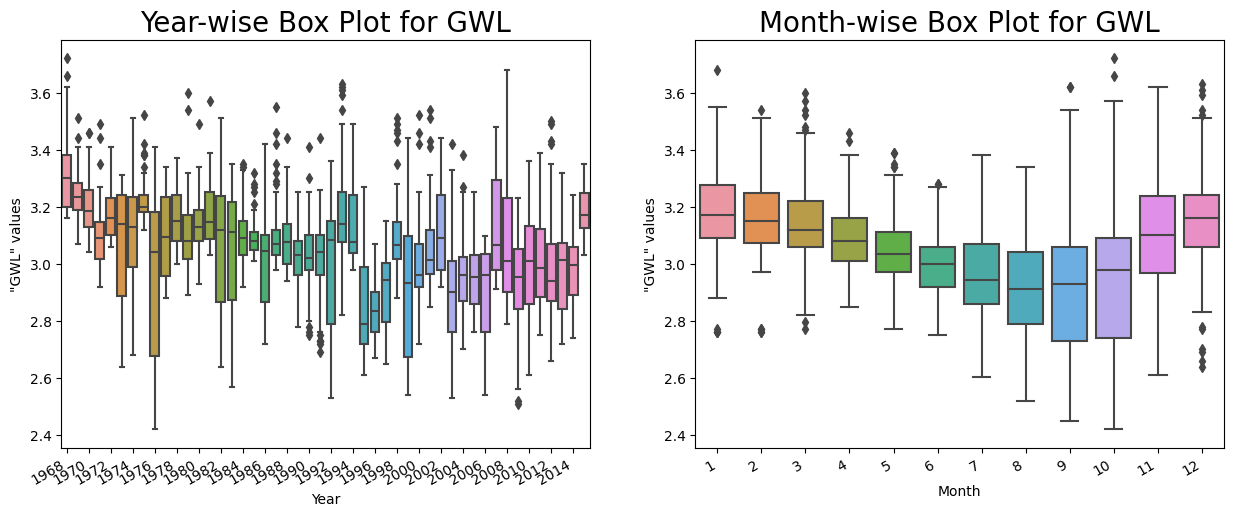

In [ ]:
# Separating the Date Component into
# Year and Month
df['Date'] = date_time
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Splitting the plot into (1,2) subplots
# and initializing them using fig and ax
# variables
fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(15, 6))

# Using Seaborn Library for Box Plot
sns.boxplot(x=df['Year'], y=df["gwl"], ax=ax[0])

# Defining the title and axes names
ax[0].set_title('Year-wise Box Plot for GWL',
                fontsize=20, loc='center')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('"GWL" values')

# Set the x-axis locator to show every two labels
ax[0].xaxis.set_major_locator(plt.MultipleLocator(2))

# change the fontsize
ax[0].tick_params(axis='x', labelsize=10)

# Using Seaborn Library for Box Plot
sns.boxplot(x=df['Month'],
            y=df["gwl"], ax=ax[1])

# Defining the title and axes names
ax[1].set_title('Month-wise Box Plot for GWL',
                fontsize=20, loc='center')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('"GWL" values')

# rotate the ticks and right align them
fig.autofmt_xdate()


In [ ]:
df

,gwl,pr,tm,Tyrsin,Tyrcos,Change,Date,Year,Month
date,,,,,,,,,
1968-07-14,3.20,11.023824,16.794464,-0.171759,-0.985139,NaN,1968-07-14,1968,7
1968-07-21,3.19,0.800202,14.949683,-0.289252,-0.957253,0.996875,1968-07-21,1968,7
1968-07-28,3.22,0.000000,15.276594,-0.402527,-0.915408,1.009404,1968-07-28,1968,7
1968-08-04,3.20,0.000000,18.337181,-0.509933,-0.860214,0.993789,1968-08-04,1968,8
1968-08-11,3.16,0.047861,15.560719,-0.609902,-0.792477,0.987500,1968-08-11,1968,8
...,...,...,...,...,...,...,...,...,...
2015-04-05,3.27,0.052624,4.329820,0.524704,-0.851284,1.028302,2015-04-05,2015,4
2015-04-12,3.14,0.585845,9.922897,0.418268,-0.908324,0.960245,2015-04-12,2015,4
2015-04-19,3.06,0.000000,8.467313,0.305732,-0.952118,0.974522,2015-04-19,2015,4


## Feature engineering + optimization

### Random Forest for time series forecasting
Training a Random Forest on time series data with time covariates involves incorporating temporal information into your features. You need to structure your dataset appropriately and consider lag features to capture temporal dependencies

In [ ]:
df_rf = df.copy()
df_rf = df_rf.drop(['Change', 'Date'], axis=1)
df_rf

,gwl,pr,tm,Tyrsin,Tyrcos,Year,Month
date,,,,,,,
1968-07-14,3.20,11.023824,16.794464,-0.171759,-0.985139,1968,7
1968-07-21,3.19,0.800202,14.949683,-0.289252,-0.957253,1968,7
1968-07-28,3.22,0.000000,15.276594,-0.402527,-0.915408,1968,7
1968-08-04,3.20,0.000000,18.337181,-0.509933,-0.860214,1968,8
1968-08-11,3.16,0.047861,15.560719,-0.609902,-0.792477,1968,8
...,...,...,...,...,...,...,...
2015-04-05,3.27,0.052624,4.329820,0.524704,-0.851284,2015,4
2015-04-12,3.14,0.585845,9.922897,0.418268,-0.908324,2015,4
2015-04-19,3.06,0.000000,8.467313,0.305732,-0.952118,2015,4


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Feature engineering: lag features for the target and covariates
lags = 4 # 1 month lags
for i in range(1, lags + 1):
    df_rf[f'gwl_lag_{i}'] = df_rf['gwl'].shift(i)
    for covariate in ['pr', 'tm']:
        df_rf[f'{covariate}_lag_{i}'] = df_rf[covariate].shift(i)

df_rf

,gwl,pr,tm,Tyrsin,Tyrcos,Year,Month,gwl_lag_1,pr_lag_1,tm_lag_1,gwl_lag_2,pr_lag_2,tm_lag_2,gwl_lag_3,pr_lag_3,tm_lag_3,gwl_lag_4,pr_lag_4,tm_lag_4
date,,,,,,,,,,,,,,,,,,,
1968-07-14,3.20,11.023824,16.794464,-0.171759,-0.985139,1968,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968-07-21,3.19,0.800202,14.949683,-0.289252,-0.957253,1968,7,3.20,11.023824,16.794464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968-07-28,3.22,0.000000,15.276594,-0.402527,-0.915408,1968,7,3.19,0.800202,14.949683,3.20,11.023824,16.794464,NaN,NaN,NaN,NaN,NaN,NaN
1968-08-04,3.20,0.000000,18.337181,-0.509933,-0.860214,1968,8,3.22,0.000000,15.276594,3.19,0.800202,14.949683,3.20,11.023824,16.794464,NaN,NaN,NaN
1968-08-11,3.16,0.047861,15.560719,-0.609902,-0.792477,1968,8,3.20,0.000000,18.337181,3.22,0.000000,15.276594,3.19,0.800202,14.949683,3.20,11.023824,16.794464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-05,3.27,0.052624,4.329820,0.524704,-0.851284,2015,4,3.18,16.721457,8.965222,3.10,0.000000,2.430592,3.12,0.076884,5.311371,3.18,0.000000,9.928102
2015-04-12,3.14,0.585845,9.922897,0.418268,-0.908324,2015,4,3.27,0.052624,4.329820,3.18,16.721457,8.965222,3.10,0.000000,2.430592,3.12,0.076884,5.311371
2015-04-19,3.06,0.000000,8.467313,0.305732,-0.952118,2015,4,3.14,0.585845,9.922897,3.27,0.052624,4.329820,3.18,16.721457,8.965222,3.10,0.000000,2.430592


In [ ]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2443 entries, 1968-07-14 to 2015-05-03
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gwl        2443 non-null   float64
 1   pr         2443 non-null   float64
 2   tm         2443 non-null   float64
 3   Tyrsin     2443 non-null   float64
 4   Tyrcos     2443 non-null   float64
 5   Year       2443 non-null   int64  
 6   Month      2443 non-null   int64  
 7   gwl_lag_1  2442 non-null   float64
 8   pr_lag_1   2442 non-null   float64
 9   tm_lag_1   2442 non-null   float64
 10  gwl_lag_2  2441 non-null   float64
 11  pr_lag_2   2441 non-null   float64
 12  tm_lag_2   2441 non-null   float64
 13  gwl_lag_3  2440 non-null   float64
 14  pr_lag_3   2440 non-null   float64
 15  tm_lag_3   2440 non-null   float64
 16  gwl_lag_4  2439 non-null   float64
 17  pr_lag_4   2439 non-null   float64
 18  tm_lag_4   2439 non-null   float64
dtypes: float64(17), int64(2)
memor

In [ ]:
df_rf['Year'] = df_rf['Year'].astype('category')
df_rf['Month'] = df_rf['Month'].astype('category')
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2443 entries, 1968-07-14 to 2015-05-03
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   gwl        2443 non-null   float64 
 1   pr         2443 non-null   float64 
 2   tm         2443 non-null   float64 
 3   Tyrsin     2443 non-null   float64 
 4   Tyrcos     2443 non-null   float64 
 5   Year       2443 non-null   category
 6   Month      2443 non-null   category
 7   gwl_lag_1  2442 non-null   float64 
 8   pr_lag_1   2442 non-null   float64 
 9   tm_lag_1   2442 non-null   float64 
 10  gwl_lag_2  2441 non-null   float64 
 11  pr_lag_2   2441 non-null   float64 
 12  tm_lag_2   2441 non-null   float64 
 13  gwl_lag_3  2440 non-null   float64 
 14  pr_lag_3   2440 non-null   float64 
 15  tm_lag_3   2440 non-null   float64 
 16  gwl_lag_4  2439 non-null   float64 
 17  pr_lag_4   2439 non-null   float64 
 18  tm_lag_4   2439 non-null   float64 
dtypes: catego

In [ ]:
df_rf.isna().sum()

gwl          0
pr           0
tm           0
Tyrsin       0
Tyrcos       0
Year         0
Month        0
gwl_lag_1    1
pr_lag_1     1
tm_lag_1     1
gwl_lag_2    2
pr_lag_2     2
tm_lag_2     2
gwl_lag_3    3
pr_lag_3     3
tm_lag_3     3
gwl_lag_4    4
pr_lag_4     4
tm_lag_4     4
dtype: int64

In [ ]:
df_rf.dropna(inplace=True)

In [ ]:
# Train-test split
#train_size = int(len(df_rf) * 0.8)
#train_data, test_data = df_rf[:train_size], df_rf[train_size:]

n = len(df_rf)
train_data = df_rf[0:int(n*0.8)]
val_data = df_rf[int(n*0.8):int(n*0.9)]
test_data = df_rf[int(n*0.9):]

# Define features and target
target = 'gwl'
target_lags = [f'gwl_lag_{i}' for i in range(1, lags + 1)]
covariate_lags = [f'{covariate}_lag_{i}' for covariate in ['pr', 'tm']]
others = ['Tyrsin',	'Tyrcos',	'Year',	'Month']
features = target_lags + covariate_lags + others

# Separate features and target in training, validation and testing sets
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Create a pipeline with StandardScaler and RandomForestRegressor
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# Hyperparameter tuning with time series cross-validation
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_leaf': [1, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_R2 = r2_score(y_val, y_val_pred)
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R2: {val_R2}')

'''# Train the final model with the best parameters
# Filter the best parameters for the RandomForestRegressor
rf_params = {key.replace('randomforestregressor__', ''): value for key, value in best_params.items() if 'randomforestregressor__' in key}
# Create the final model
final_model = make_pipeline(StandardScaler(), RandomForestRegressor(**rf_params))
#final_model = make_pipeline(StandardScaler(), RandomForestRegressor(**best_params))
final_model.fit(X_train, y_train)'''

# Make predictions
y_test_pred = best_model.predict(X_test)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_test_pred)
test_R2 = r2_score(y_test, y_test_pred)
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R2: {test_R2}')

Validation Mean Squared Error: 0.005929586422864203
Validation R2: 0.8657628741985826
Test Mean Squared Error: 0.0040184190245398325
Test R2: 0.8597940969470637


In [ ]:
best_params

{'randomforestregressor__max_depth': None,
 'randomforestregressor__min_samples_leaf': 10,
 'randomforestregressor__n_estimators': 200}

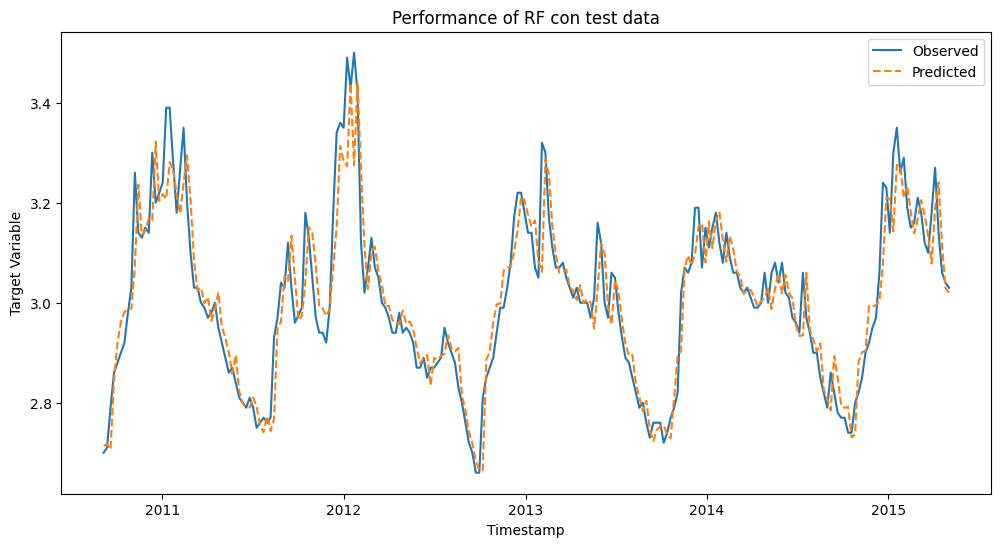

In [ ]:
# Assuming y_test is the observed values and y_pred is the predicted values
plt.figure(figsize=(12, 6))

# Plotting the observed values
plt.plot(test_data.index, y_test, label='Observed', linestyle='-')

# Plotting the predicted values
plt.plot(test_data.index, y_test_pred, label='Predicted', linestyle='--')

plt.title('Performance of RF con test data')
plt.xlabel('Timestamp')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

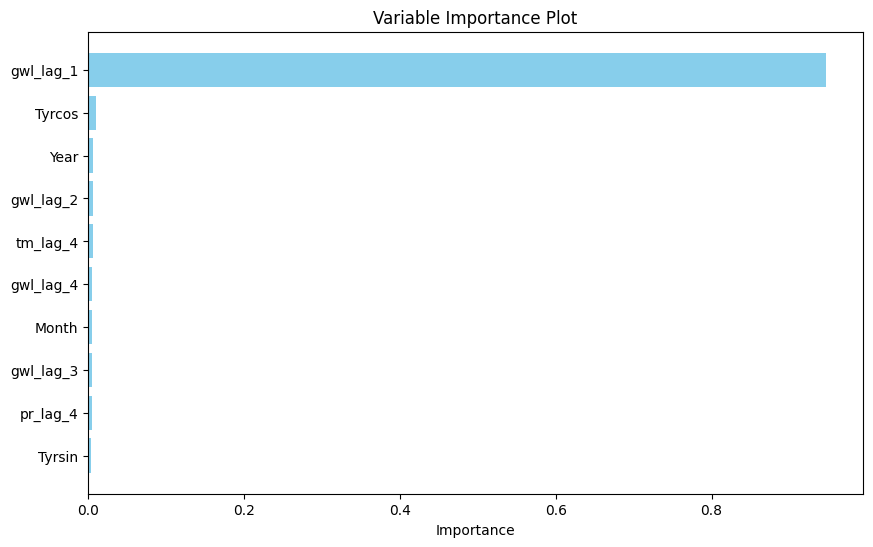

In [ ]:
# Extract feature importances from the model
importances = best_model.named_steps.randomforestregressor.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plotting the variable importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Variable Importance Plot')
plt.show()

The RF model suggests that a simple AR model could be enough to model this data.

## Model selection

## Training

### Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature. In particular, due to GWL time series variation, it is consider benficial to scale the values between -1 and 1.  Normalizing the data helps to ensure that the CNN is not biased.

In [ ]:
#scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl.fit(pd.DataFrame(df['gwl']))
df_n = pd.DataFrame(scaler.fit_transform(df[['gwl','pr','tm','Tyrsin', 'Tyrcos']]),
                    index=df.index,
                    columns=['gwl','pr','tm','Tyrsin', 'Tyrcos'])

### Split the data

We'll use a (80%, 10%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_dfn = df_n[0:int(n*0.8)]
val_dfn = df_n[int(n*0.8):int(n*0.9)]
test_dfn = df_n[int(n*0.9):]
dates_test=date_time[int(n*0.9):]

### Sequential data (windowing)

The GWL time series data is input into the model as smaller sequences or "windows". Each subsequence capture a segment of the time series and therefore, the patterns inside these segments that the model will learn during the training. Here, we should define the sequence length (`sl`), which is an hyperparameter.

Depending on the task and type of model you may want to generate a variety of data windows. For instance,  a single prediction a week into the future, given 6 weeks of history look like:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

In [ ]:
def seq_length(df, features, target, sequence_length):

  f_df=df[features]
  t_df=df[target]

  Xn, yn = [], []

  for i in range(len(f_df) - sequence_length):
      Xn.append(f_df[i : i + sequence_length])
      yn.append(t_df.iloc[i + sequence_length])

  Xn, yn = np.array(Xn), np.array(yn)

  return Xn, yn


f=['gwl','pr', 'tm','Tyrsin']
t=['gwl']

sl=10 #Sequence length
Xn_train, yn_train= seq_length(train_dfn, features=f, target=t, sequence_length=sl)
Xn_val, yn_val= seq_length(val_dfn, features=f, target=t, sequence_length=sl)
Xn_test, yn_test= seq_length(test_dfn, features=f, target=t, sequence_length=sl)



## CNN model

First, let's build a 1D Convolutional Neural Network (CNN).
A convolution layer (`tf.keras.layers.Conv1D`) takes multiple time steps as input to each prediction. The network parameters to be tuned are:


*   `filters` : number of windows moving across the input data to detect features. (usually selected as a power of 2 e.g. 32, 64, 128).
*   `kernel_size`: define the size of the filters, usuarlly 3. Small kernel sizes capture better patterns and details in the input data.
*   `activation` : the activation function applied after convolution ('RELU' stands for rectified linear unit and it is the most popular activation function)
*    `units`: The number of neurons in the layer.
*   `padding` : set to 'same' means the model output size is the same as the input

The (`seed`) allow to ensure reproducibility, meaning that every time we run the code we obtain the same results. This value is arbitrary and usually an integer.



In [ ]:
ini=1

tf.random.set_seed(ini+500)

# Define your CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sl, df[f].shape[1]), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

On the model compilation we should define the following:

*   `optimizer`: The choice of optimizer (e.g., 'adam', 'sgd', etc.). Adam optimization algorithm is the most used one and states for Adaptive Moment Estimation. Ajust the weights of the neural network to minimize the loss function.
*   `loss`: The loss function used during training. Here Mean Squared Error `mse` is used as it is common on regression tasks.
*   `metrics`: define which metric to track during training.

### Optimization

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            416       
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                20544     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model summary shows the model architecture we have built.


1.   **conv1d layer** : 3D tensor  (batch_size, sequence_length, number_of_filters) with 416 parameters (weights + bias)
2.   **fatten layer** : Flattens the 3D tensor into a 1D tensor.
3.   **Dense layer 1** : fully connected layer with the number of units (previously defined) as shapes.
4.   **Dense layer 2** : fully connected layer with the final output shape.



For **training the model** we define the number of `epochs` (in each epoch the model is trained through the entire dataset, updating the weights and biases). An adequate number of epochs creates a balance between overfitting and underfitting.

Here we add a regularization technique known as early stopping which help preventing overfitting. The main idea is to stop the training once the performance stops improving. The `patience` states for the number of epochs with no improvement after which training will be stopped.


In [ ]:
# Train the model
epochs = 20
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15, restore_best_weights = True)

history = model.fit(Xn_train, yn_train, epochs=epochs, validation_data=(Xn_val, yn_val), batch_size=32, verbose=1, callbacks=[es])

Epoch 1/20
61/61 [==============================] - 1s 7ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 3/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 4/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 6/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 7/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 8/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0113 - mse: 0.01

### Model evaluation

In [ ]:
# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(Xn_val, yn_val)
print(f'Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}')

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(Xn_test, yn_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Make predictions on the validation and test sets
yn_val_pred = model.predict(Xn_val)
yn_test_pred = model.predict(Xn_test)

# Calculate R² for validation set
r2_val = r2_score(yn_val, yn_val_pred)
print(f'Validation R²: {r2_val:.4f}')

# Calculate R² for test set
r2_test = r2_score(yn_test, yn_test_pred)
print(f'Test R²: {r2_test:.4f}')

# Calculate NSE for test set
err=yn_test_pred- np.mean(np.asarray(yn_train))
nse_test = 1 - np.sum((yn_test - yn_test_pred)**2) / np.sum((err)**2)
print(f'Test NSE: {nse_test:.4f}')

8/8 [==============================] - 0s 3ms/step - loss: 0.0149 - mse: 0.0149
Validation Loss: 0.0149, Validation MAE: 0.0149
8/8 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113
Test Loss: 0.0113, Test MAE: 0.0113
8/8 [==============================] - 0s 3ms/step
Validation R²: 0.8620
Test R²: 0.8325
Test NSE: 0.8526


### Plot the results

First we should inverse the normalization to plot the actual groundwater level values.

In [ ]:
y_test_pred = scaler_gwl.inverse_transform(yn_test_pred)
y_test = scaler_gwl.inverse_transform(yn_test)

#Dates of the test set
dates_testv=dates_test[:len(dates_test)-sl].values

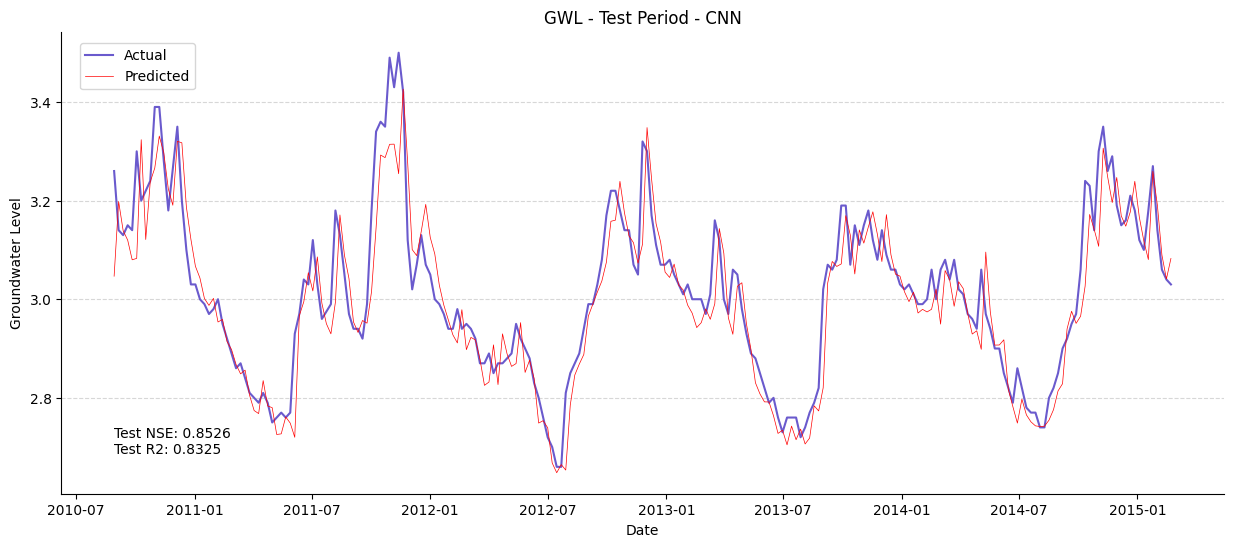

In [ ]:
plt.figure(figsize=(15, 6))

z = 1000  # zoom

# Plot the actual values during the test period
plt.plot(dates_testv[:z], y_test[:z], label='Actual', color='slateblue')

# Plot the predicted values during the test period
plt.plot(dates_testv[:z], y_test_pred[:z], label='Predicted', color='red', linestyle='-', linewidth=0.5)

# Display performance measures on the plot
plt.text(dates_testv[0], 1.01 * np.min(y_test), f'Test NSE: {nse_test:.4f}\nTest R2: {r2_test:.4f}', color='black')

# Set legend inside the plot
legend = plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Remove the right and upper frame
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add horizontal grids with high opacity
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.title('GWL - Test Period - CNN')
plt.xlabel('Date')
plt.ylabel('Groundwater Level')
plt.show()

## Long-Short-Term Memory (LSTM) network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units=32, activation='tanh', recurrent_activation='sigmoid',
                         dropout=0.2 , recurrent_dropout=0.005,
                         kernel_initializer='zeros', bias_initializer='zeros',  input_shape=(sl, df[f].shape[1])),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# Build the model
batch_size=32
lstm_model.build(input_shape=(batch_size, sl, df[f].shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print the model summary
lstm_model.summary()

# Train the model
epochs = 50  ###

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15, restore_best_weights = True)

history = lstm_model.fit(Xn_train, yn_train, epochs=epochs, validation_data=(Xn_val, yn_val), batch_size=32, verbose=0, callbacks=[es])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Make predictions on the validation and test sets
yn_val_pred = lstm_model.predict(Xn_val)
yn_test_pred = lstm_model.predict(Xn_test)

8/8 [==============================] - 0s 5ms/step


In [ ]:
# Evaluate the model on the validation set
val_loss, val_mae = lstm_model.evaluate(Xn_val, yn_val)
print(f'Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}')

# Evaluate the model on the test set
test_loss, test_mae = lstm_model.evaluate(Xn_test, yn_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Calculate R² for validation set
r2_val = r2_score(yn_val, yn_val_pred)
print(f'Validation R²: {r2_val:.4f}')

# Calculate R² for test set
r2_test = r2_score(yn_test, yn_test_pred)
print(f'Test R²: {r2_test:.4f}')

# Calculate NSE for test set
err=yn_test_pred- np.mean(np.asarray(yn_train))
nse_test = 1 - np.sum((yn_test - yn_test_pred)**2) / np.sum((err)**2)
print(f'Test NSE: {nse_test:.4f}')

8/8 [==============================] - 0s 4ms/step - loss: 0.0155 - mse: 0.0155
Validation Loss: 0.0155, Validation MAE: 0.0155
8/8 [==============================] - 0s 4ms/step - loss: 0.0105 - mse: 0.0105
Test Loss: 0.0105, Test MAE: 0.0105
Validation R²: 0.8556
Test R²: 0.8440
Test NSE: 0.8137


In [ ]:
y_test_pred = scaler_gwl.inverse_transform(yn_test_pred)
y_test = scaler_gwl.inverse_transform(yn_test)

In [ ]:
#Dates of the test set
dates_testv=dates_test[:len(dates_test)-sl].values

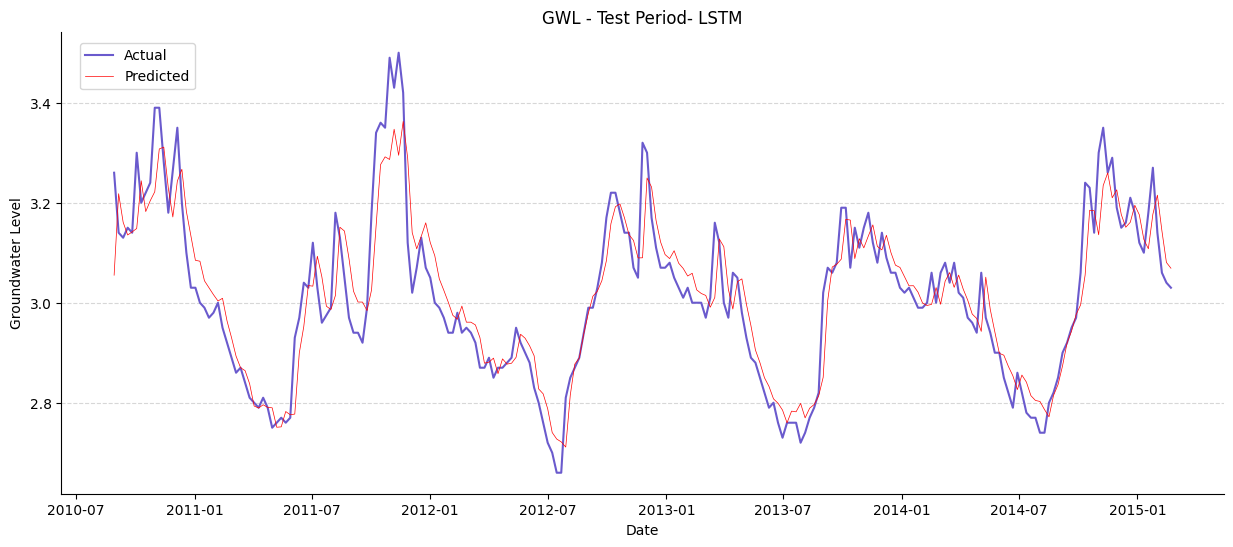

In [ ]:
plt.figure(figsize=(15, 6))

# Plot the actual values during the test period
plt.plot( dates_testv, y_test , label='Actual', color='slateblue')

# Plot the predicted values during the test period
plt.plot( dates_testv,  y_test_pred, label='Predicted', color='red', linestyle='-', linewidth=0.5)

# Display performance measures on the plot
#plt.text(dates_testv[0], 1.01 * np.min(y_test), f'Test NSE: {nse_test:.4f}\nTest R2: {r2_test:.4f}', color='black')

# Set legend inside the plot
legend = plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Remove the right and upper frame
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add horizontal grids with high opacity
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.title('GWL - Test Period- LSTM')
plt.xlabel('Date')
plt.ylabel('Groundwater Level')
plt.show()